In [1]:
import pandas as pd
import numpy as np
import funciones
import statistics
import matplotlib.pyplot as plt
import os
from collections import Counter

In [2]:
shdf= pd.read_csv(("input/GSAF5.csv"), engine = "python")
display(shdf)
#Accedo a la base de datos para mostrar el dataframe en raw

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN
5,2016.09.15.R,15-Sep-16,2016,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,...,NaN,"West Australian, 9/15/2016",2016.09.15.R-boat.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.15.R,2016.09.15.R,5988,NaN,NaN
6,2016.09.11,11-Sep-16,2016,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,...,3' to 4' shark,"News4Jax, 9/11/2016",2016.09.11-PonteVedra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.11,2016.09.11,5987,NaN,NaN
7,2016.09.07,07-Sep-16,2016,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,...,"Tiger shark, 10?","Hawaii News Now, 9/7/2016",2016.09.07-Oahu.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.07,2016.09.07,5986,NaN,NaN
8,2016.09.06,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,...,NaN,"TVANouvelles, 9/6/2016",2016.09.06-Jewell.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.06,2016.09.06,5985,NaN,NaN
9,2016.09.05.b,05-Sep-16,2016,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,...,NaN,"C. Creswell, GSAF",2016.09.05.b-Williams.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.05.b,2016.09.05.b,5984,NaN,NaN


In [3]:
shdf.columns
#Busco las columnas para conocer el nombre y elegir qcon qué me quedo para empezar a limpiar.
#Acabo de darme cuenta que en el guadalquivir un tiburón se zampó a un señor que nadaba tan tranquilo hace más de 80 años.



Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')

In [4]:
shdf.describe()
# Uso el decribe para ver los datos estadísticos y veo que hay muy pocas columnas ed tipo float


,Year,original order
count,5992.000000,5992.000000
mean,1925.204606,2997.548899
std,286.473712,1729.860210
min,0.000000,2.000000
25%,1942.000000,1499.750000
50%,1975.000000,2997.500000
75%,2003.000000,4495.250000
max,2016.000000,5993.000000


In [5]:
# la columna Sex y Species tienen un espacio al final, voy a renombrar varias columnas para
#deshacerme de ese fallo y darle un properly name a las columnas que quiero usar

#SEX , SPECIES 
shdf.rename(columns={"Sex ":"Sex","Species ":"Species"},inplace=True)
shdf

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN
5,2016.09.15.R,15-Sep-16,2016,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,...,NaN,"West Australian, 9/15/2016",2016.09.15.R-boat.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.15.R,2016.09.15.R,5988,NaN,NaN
6,2016.09.11,11-Sep-16,2016,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,...,3' to 4' shark,"News4Jax, 9/11/2016",2016.09.11-PonteVedra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.11,2016.09.11,5987,NaN,NaN
7,2016.09.07,07-Sep-16,2016,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,...,"Tiger shark, 10?","Hawaii News Now, 9/7/2016",2016.09.07-Oahu.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.07,2016.09.07,5986,NaN,NaN
8,2016.09.06,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,...,NaN,"TVANouvelles, 9/6/2016",2016.09.06-Jewell.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.06,2016.09.06,5985,NaN,NaN
9,2016.09.05.b,05-Sep-16,2016,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,...,NaN,"C. Creswell, GSAF",2016.09.05.b-Williams.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.05.b,2016.09.05.b,5984,NaN,NaN


In [6]:
shdf.dtypes
#Reviso los tipos de datos. Sólo hay dos columnas de tipo entero y tendré que convertir el type de dato por columnas.


Case Number               object
Date                      object
Year                       int64
Type                      object
Country                   object
Area                      object
Location                  object
Activity                  object
Name                      object
Sex                       object
Age                       object
Injury                    object
Fatal (Y/N)               object
Time                      object
Species                   object
Investigator or Source    object
pdf                       object
href formula              object
href                      object
Case Number.1             object
Case Number.2             object
original order             int64
Unnamed: 22               object
Unnamed: 23               object
dtype: object

In [7]:
shdf=shdf.rename(columns={"Species ":"Species"})
#renombro columnas con nombre erroneo

pd.isnull(shdf["Species"]).values.ravel().sum()
#cuento cuantos nulls hay en la columna elegida





2934

In [8]:
# cambio los valores null por "No data" por no eliminar casi 3000 registros, que aunque 
# el dato de esa columna no es decisivo para mi estudio, quiero conservar esas filas.
shdf["Species"].fillna("NO DATA")
shdf

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN
5,2016.09.15.R,15-Sep-16,2016,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,...,NaN,"West Australian, 9/15/2016",2016.09.15.R-boat.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.15.R,2016.09.15.R,5988,NaN,NaN
6,2016.09.11,11-Sep-16,2016,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,...,3' to 4' shark,"News4Jax, 9/11/2016",2016.09.11-PonteVedra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.11,2016.09.11,5987,NaN,NaN
7,2016.09.07,07-Sep-16,2016,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,...,"Tiger shark, 10?","Hawaii News Now, 9/7/2016",2016.09.07-Oahu.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.07,2016.09.07,5986,NaN,NaN
8,2016.09.06,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,...,NaN,"TVANouvelles, 9/6/2016",2016.09.06-Jewell.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.06,2016.09.06,5985,NaN,NaN
9,2016.09.05.b,05-Sep-16,2016,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,...,NaN,"C. Creswell, GSAF",2016.09.05.b-Williams.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.05.b,2016.09.05.b,5984,NaN,NaN


In [9]:

#al ver el output, decido no tener en cuenta la columna especies
shdf=shdf.drop(["Species"],axis=1)
shdf

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Time,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,13h00,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,11h00,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,10h43,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,NaN,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN
5,2016.09.15.R,15-Sep-16,2016,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,...,NaN,"West Australian, 9/15/2016",2016.09.15.R-boat.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.15.R,2016.09.15.R,5988,NaN,NaN
6,2016.09.11,11-Sep-16,2016,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,...,15h15,"News4Jax, 9/11/2016",2016.09.11-PonteVedra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.11,2016.09.11,5987,NaN,NaN
7,2016.09.07,07-Sep-16,2016,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,...,14h30,"Hawaii News Now, 9/7/2016",2016.09.07-Oahu.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.07,2016.09.07,5986,NaN,NaN
8,2016.09.06,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,...,15h40,"TVANouvelles, 9/6/2016",2016.09.06-Jewell.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.06,2016.09.06,5985,NaN,NaN
9,2016.09.05.b,05-Sep-16,2016,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,...,Late afternoon,"C. Creswell, GSAF",2016.09.05.b-Williams.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.05.b,2016.09.05.b,5984,NaN,NaN


In [10]:
# al ver el output decido eliminar más columnas malvadas

# case number, name, investigtor or source, pdf, 
# href formula, href, case number 1, case number 2, original order, unnamed22, unnamed 23
shdf=shdf.drop(["Case Number"],axis=1)
shdf=shdf.drop(["Name"],axis=1)
shdf=shdf.drop(["Investigator or Source"],axis=1)
shdf=shdf.drop(["pdf"],axis=1)
shdf=shdf.drop(["href formula"],axis=1)
shdf=shdf.drop(["href"],axis=1)
shdf=shdf.drop(["Case Number.1"],axis=1)
shdf=shdf.drop(["Case Number.2"],axis=1)
shdf=shdf.drop(["original order"],axis=1)
shdf=shdf.drop(["Unnamed: 22"],axis=1)
shdf=shdf.drop(["Unnamed: 23"],axis=1)

shdf






,Date,Year,Type,Country,Area,Location,Activity,Sex,Age,Injury,Fatal (Y/N),Time
0,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,M,16,Minor injury to thigh,N,13h00
1,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,M,36,Lacerations to hands,N,11h00
2,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,M,43,Lacerations to lower leg,N,10h43
3,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,M,NaN,Struck by fin on chest & leg,N,NaN
4,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,M,NaN,No injury: Knocked off board by shark,N,NaN
5,15-Sep-16,2016,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,NaN,NaN,Shark rammed boat. No injury to occupant,N,NaN
6,11-Sep-16,2016,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,M,60s,Minor injury to arm,N,15h15
7,07-Sep-16,2016,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,F,51,Severe lacerations to shoulder & forearm,N,14h30
8,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,M,50,FATAL,Y,15h40
9,05-Sep-16,2016,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,F,12,Lacerations & punctures to lower right leg,N,Late afternoon


In [11]:
print(shdf.shape)
print(shdf.columns)
# compruebo como ha quedado el dataframe

(5992, 12)
Index(['Date', 'Year', 'Type', 'Country', 'Area', 'Location', 'Activity',
       'Sex', 'Age', 'Injury', 'Fatal (Y/N)', 'Time'],
      dtype='object')


In [12]:
# compruebo con el output que la columna "Sex " tiene un espacio y renombro la columna
shdf=shdf.rename(columns={"Sex ":"Sex"})
print("Sex nulls: ", pd.isnull(shdf["Sex"]).values.ravel().sum())


# compruebo los nulls de las columnas restantes con una función
funciones.check_nulls(shdf)

Sex nulls:  567
Date nulls:  0
Year nulls:  0
Type nulls:  0
Country nulls:  43
Area nulls:  402
Location nulls:  496
Activity nulls:  527
Age nulls:  2681
Injury nulls:  27
Fatal (Y/N) nulls:  19
Time:  3213


In [13]:
# procedo a cambiar el tipo de dato de objeto a int donde sea posible
# en este caso la columna AGE

shdf['Age'] = pd.to_numeric(shdf['Age'], errors='coerce').fillna(0)

shdf['Age'] = shdf['Age'].astype(np.int64)

print("Tipo de dato en col AGE: ", shdf["Age"].dtype)
#compruebo que ahora el tipo es int

funciones.check_nulls(shdf)
# los age null igual 0

Tipo de dato en col AGE:  int64
Date nulls:  0
Year nulls:  0
Type nulls:  0
Country nulls:  43
Area nulls:  402
Location nulls:  496
Activity nulls:  527
Age nulls:  0
Injury nulls:  27
Fatal (Y/N) nulls:  19
Time:  3213


In [14]:
# la siguiente columna a tratar sería TIME por tener tantos nulls, pero teniendo tantos valores nulos, 
# pienso que para usar este parámetro, la recogida de datos debería ser más limpia. 3000 nulls son 
# muchos nulls diferentes para tratar. Decido eliminar la columna.
shdf=shdf.drop(["Time"],axis=1)
shdf






,Date,Year,Type,Country,Area,Location,Activity,Sex,Age,Injury,Fatal (Y/N)
0,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,M,16,Minor injury to thigh,N
1,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,M,36,Lacerations to hands,N
2,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,M,43,Lacerations to lower leg,N
3,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,M,0,Struck by fin on chest & leg,N
4,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,M,0,No injury: Knocked off board by shark,N
5,15-Sep-16,2016,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,NaN,0,Shark rammed boat. No injury to occupant,N
6,11-Sep-16,2016,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,M,0,Minor injury to arm,N
7,07-Sep-16,2016,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,F,51,Severe lacerations to shoulder & forearm,N
8,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,M,50,FATAL,Y
9,05-Sep-16,2016,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,F,12,Lacerations & punctures to lower right leg,N


In [15]:
# conmpruebo la columna Sex de nuevo, para intentar limpiar los datos 
print("Sex nulls: ", pd.isnull(shdf["Sex"]).values.ravel().sum())

Sex nulls:  567


In [16]:
# creo una variable dummy para la columna Sex

dummy_sex= pd.get_dummies(shdf["Sex"], prefix= "Sex")
dummy_sex.head(20)
# no sé por que aparece una columna más con Sex_M 


,Sex_.,Sex_F,Sex_M,Sex_M,Sex_N,Sex_lli
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0
5,0,0,0,0,0,0
6,0,0,1,0,0,0
7,0,1,0,0,0,0
8,0,0,1,0,0,0
9,0,1,0,0,0,0


In [17]:
dummy_sex=dummy_sex.drop(["Sex_."],axis=1)
dummy_sex=dummy_sex.drop(["Sex_N"],axis=1)
dummy_sex=dummy_sex.drop(["Sex_lli"],axis=1)
dummy_sex=dummy_sex.drop(dummy_sex.columns[[2]],axis=1)
# tabla creada en función de los datos encontrados en la col Sex, 
# una vez tenngo la tabla, he eliminado las columnas que tenían datos incorrectos
# por tanto el resultado es una tabla con m/f

dummy_sex.head(200)

,Sex_F,Sex_M
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
5,0,0
6,0,1
7,1,0
8,0,1
9,1,0


In [18]:

# intercambiar la columna sex por dummy_sex
# limpiar nulos
# conclusiones


In [19]:
shdf=shdf.drop(["Sex"],axis=1)
shdf = pd.concat([shdf, dummy_sex], axis=1)
shdf=shdf.rename(columns={"Sex_F":"Female"})
shdf=shdf.rename(columns={"Sex_M":"Male"})
shdf
# añado la tabla dummy_sex al dataframe y renombro las columnas
# lets go con comprobar más nulos

,Date,Year,Type,Country,Area,Location,Activity,Age,Injury,Fatal (Y/N),Female,Male
0,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,16,Minor injury to thigh,N,0,1
1,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,36,Lacerations to hands,N,0,1
2,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,43,Lacerations to lower leg,N,0,1
3,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,0,Struck by fin on chest & leg,N,0,1
4,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,0,No injury: Knocked off board by shark,N,0,1
5,15-Sep-16,2016,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,0,Shark rammed boat. No injury to occupant,N,0,0
6,11-Sep-16,2016,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,0,Minor injury to arm,N,0,1
7,07-Sep-16,2016,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,51,Severe lacerations to shoulder & forearm,N,1,0
8,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,50,FATAL,Y,0,1
9,05-Sep-16,2016,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,12,Lacerations & punctures to lower right leg,N,1,0


In [20]:
shdf.dtypes
# me ha dado por comprobar el tio de dato en las cols que he añadido y me he llevado una 
# sorpresita (no se si buena o mala pero lo convierto a int y punto)

Date           object
Year            int64
Type           object
Country        object
Area           object
Location       object
Activity       object
Age             int64
Injury         object
Fatal (Y/N)    object
Female          uint8
Male            uint8
dtype: object

In [21]:
shdf['Female'] = pd.to_numeric(shdf['Female'], errors='coerce').fillna(0)
shdf['Female'] = shdf['Female'].astype(np.int64)
print("Tipo de dato en col Female: ", shdf["Female"].dtype)

shdf['Male'] = pd.to_numeric(shdf['Male'], errors='coerce').fillna(0)
shdf['Male'] = shdf['Male'].astype(np.int64)
print("Tipo de dato en col Male: ", shdf["Male"].dtype)

# compruebo los nulls de nuevo para recordarme como voy (con la función funciones.check_nulls(shdf) )
# obvio el error de la col Time porque es un error esperado ya que ya no se puede
# comprobar porque la dropeamos (no sé como decirle a la función que si está ejecute
# y si no está que no ejecute pero me gustaría saber como se podría hacer, TA`s me lo podéis contar?)

Tipo de dato en col Female:  int64
Tipo de dato en col Male:  int64


In [22]:
shdf

,Date,Year,Type,Country,Area,Location,Activity,Age,Injury,Fatal (Y/N),Female,Male
0,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,16,Minor injury to thigh,N,0,1
1,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,36,Lacerations to hands,N,0,1
2,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,43,Lacerations to lower leg,N,0,1
3,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,0,Struck by fin on chest & leg,N,0,1
4,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,0,No injury: Knocked off board by shark,N,0,1
5,15-Sep-16,2016,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,0,Shark rammed boat. No injury to occupant,N,0,0
6,11-Sep-16,2016,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,0,Minor injury to arm,N,0,1
7,07-Sep-16,2016,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,51,Severe lacerations to shoulder & forearm,N,1,0
8,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,50,FATAL,Y,0,1
9,05-Sep-16,2016,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,12,Lacerations & punctures to lower right leg,N,1,0


In [23]:
#funciones.check_nulls(shdf)

#fatal
pd.isnull(shdf["Fatal (Y/N)"]).values.ravel().sum()

19

In [24]:
shdf["Fatal (Y/N)"] = shdf["Fatal (Y/N)"].fillna("NO DATA")
shdf["Country"] = shdf["Country"].fillna("NO DATA")
shdf["Area"] = shdf["Area"].fillna("NO DATA")
shdf["Location"] = shdf["Location"].fillna("NO DATA")
shdf["Activity"] = shdf["Activity"].fillna("NO DATA")
# relleno datos faltantes en las cols
#country, area, location, activity, injury, fatal

In [25]:
#funciones.check_nulls(shdf)
injury_mode= statistics.mode(shdf["Injury"])
shdf["Injury"] = shdf["Injury"].fillna(injury_mode)
print(injury_mode)
#calculamos la moda de la col Fatal, para obtener el dato con que completar los datos faltantes

FATAL


In [26]:
# funciones.check_nulls(shdf)
# Ahora estan todos los datos "completos"

In [27]:
shdf.to_csv('clean_shark.csv')
#importación del csv limpio


# Graphs

In [28]:
%matplotlib inline

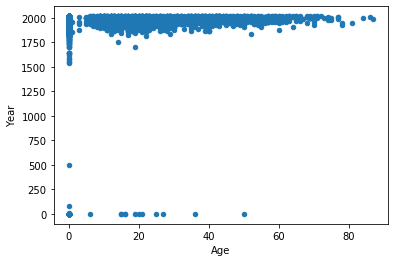

In [29]:
shdf.plot(kind="scatter",x="Age",y="Year")
# una graciosa prueba para ver las edades con más ataques en todo el registro.


{'whiskers': [<matplotlib.lines.Line2D at 0x1ff94a596d8>,
 'caps': [<matplotlib.lines.Line2D at 0x1ff94a59ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ff94a59240>],
 'medians': [<matplotlib.lines.Line2D at 0x1ff94a5e4e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ff94a5eb38>],
 'means': []}

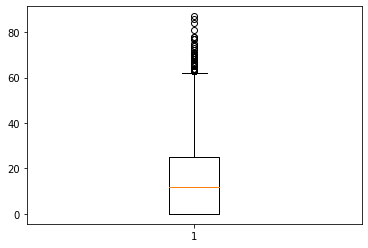

In [30]:
plt.boxplot(shdf["Age"])
# outliers de edad ya que parece que la gente de avanzada edad no suele estar
# cerca del peligro de un tiburón.
# Así que si Alberto quiere montar una agencia de actividades para
# la tercera edad, (contando con otro estudio paralelo sobre la aceptación
# de actividades físicas en el medio acuático), podría o no recomendarle
# que ofreciera esa actividad a es público

In [31]:
# años 2016 / pais(es) con más ataques
# sacar datos del 2016 y filtrar por país
# count año, para saber cuantos datos hay en cada año
# funcion que reciba 2 años inicia final + df- ataques en esos años por pais
funciones.ataques_ano_pais(shdf,2015,2016)
# top países 2015-2016 con más registros de ataques
    
    
    

[('USA', 124),
 ('AUSTRALIA', 53),
 ('SOUTH AFRICA', 12),
 ('BAHAMAS', 7),
 ('NEW CALEDONIA', 6)]

In [39]:
#shdf["Injury"].unique()
shdf["Injury"].value_counts()
# Quería saber también que palabras se repiten más en la columna Injurys cuando se habla de tiburones

TypeError: 'tuple' object is not callable